In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
df = pd.read_csv('cleaned_turbo_az.csv')

In [92]:
features = ['price_azn', 'year', 'mileage', 'engine', 'horse_power', 'n_views']
X = df[features]

# Scale features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

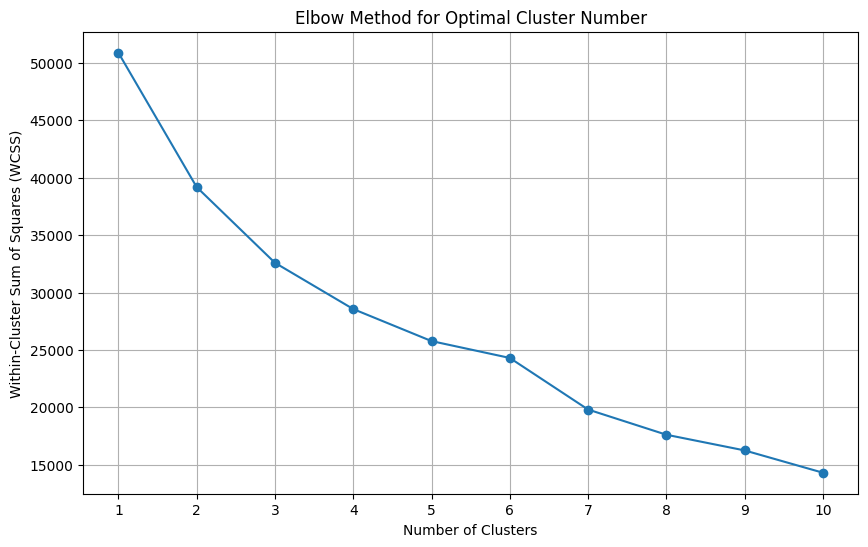

In [93]:
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

In [94]:
# Apply K-Means with selected clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Cluster statistics using original feature values
cluster_stats = df.groupby('cluster')[features].mean()

**1. Car Market Segments by Price and Year**


Detailed Market Segment Analysis:
                        persona  count  percentage      price_azn  \
cluster                                                             
0           Affordable Classics   2910        34.3   13094.979381   
1          Mainstream Moderates   4185        49.3   35940.680048   
2        Premium Luxury Segment    576         6.8  161591.293403   
3              Value Performers    811         9.6   43877.632552   

                year        mileage    engine  horse_power      n_views  
cluster                                                                  
0        2004.020275  267081.347423  1.959416   127.291409  1635.332646  
1        2018.182557   93490.478614  1.856487   183.135006  4620.055197  
2        2021.954861   25380.112847  2.375000   433.204861  6052.979167  
3        2010.286067  223098.434032  4.502219   330.981504  3185.167694  


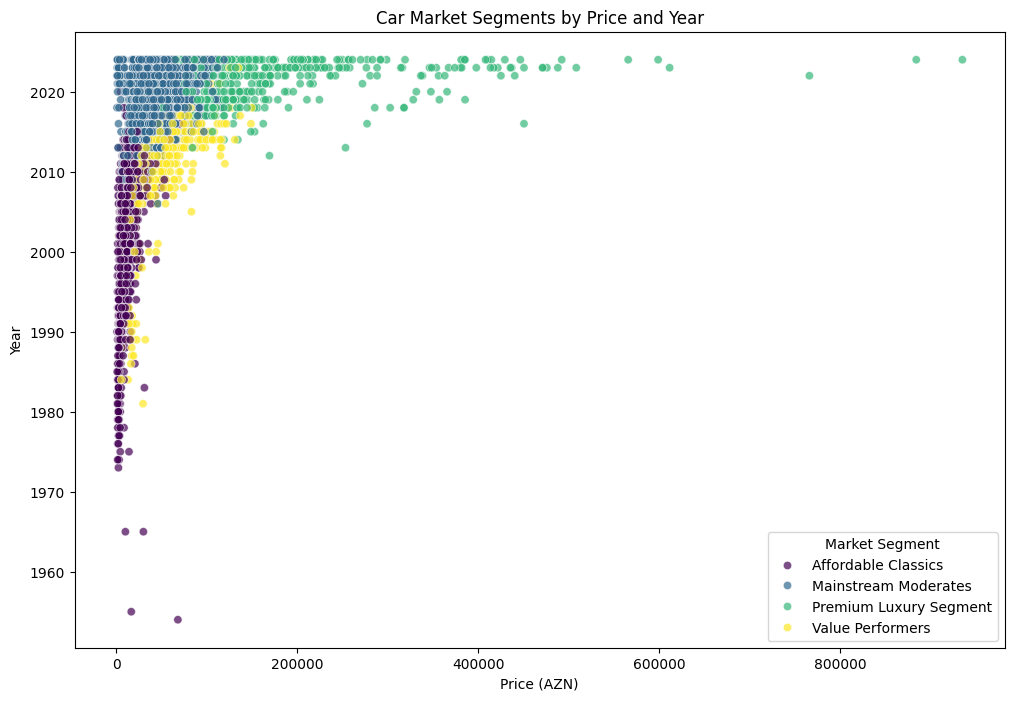

In [95]:
# Define cluster personas based on characteristics
cluster_personas = {
    0: "Affordable Classics",
    1: "Mainstream Moderates",
    2: "Premium Luxury Segment",
    3: "Value Performers"
}

# Map cluster numbers to persona names
df['persona'] = df['cluster'].map(cluster_personas)

# Visualize clusters with persona labels using ORIGINAL (non-standardized) values
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='price_azn',  # Using original price
    y='year',       # Using original year
    hue='cluster', 
    palette='viridis',
    data=df, 
    alpha=0.7
)

# Create legend with persona names instead of cluster numbers
handles, labels = scatter.get_legend_handles_labels()
new_labels = [f"{cluster_personas[int(label)]}" for label in labels]
plt.legend(handles=handles, labels=new_labels, title="Market Segment", loc='lower right')

plt.title('Car Market Segments by Price and Year')
plt.xlabel('Price (AZN)')
plt.ylabel('Year')

# Create a more detailed summary table with personas
summary = pd.DataFrame(cluster_stats)
summary['count'] = df['cluster'].value_counts().sort_index()
summary['percentage'] = (summary['count'] / len(df) * 100).round(1)
summary['persona'] = [cluster_personas[i] for i in summary.index]

# Reorder columns to put persona first
cols = ['persona', 'count', 'percentage'] + features
summary = summary[cols]

print("\nDetailed Market Segment Analysis:")
print(summary)

In [96]:
# Calculate mean values for each cluster
cluster_profiles = df.groupby('cluster')[features].mean()

# Calculate size of each cluster
cluster_profiles['count'] = df['cluster'].value_counts().sort_index()

# Calculate z-scores to show how clusters differ from overall mean
for feature in features:
    overall_mean = df[feature].mean()
    overall_std = df[feature].std()
    cluster_profiles[f'{feature}_zscore'] = (
        (cluster_profiles[feature] - overall_mean) / overall_std
    )

print("Detailed Cluster Profiles:")
print(cluster_profiles)

Detailed Cluster Profiles:
             price_azn         year        mileage    engine  horse_power  \
cluster                                                                     
0         13094.979381  2004.020275  267081.347423  1.959416   127.291409   
1         35940.680048  2018.182557   93490.478614  1.856487   183.135006   
2        161591.293403  2021.954861   25380.112847  2.375000   433.204861   
3         43877.632552  2010.286067  223098.434032  4.502219   330.981504   

             n_views  count  price_azn_zscore  year_zscore  mileage_zscore  \
cluster                                                                      
0        1635.332646   2910         -0.507312    -1.004442        0.758174   
1        4620.055197   4185         -0.030351     0.611203       -0.480315   
2        6052.979167    576          2.592923     1.041551       -0.966250   
3        3185.167694    811          0.135353    -0.289635        0.444377   

         engine_zscore  horse_power_zscor

**2. Brand Clusters: Identification of brands that dominate specific market segments.**

In [97]:
brand_persona_counts = df.groupby(['make', 'persona']).size().unstack(fill_value=0)

top_brands = brand_persona_counts.sum(axis=1).sort_values(ascending=False).head(15)
brand_persona_top = brand_persona_counts.loc[top_brands.index]

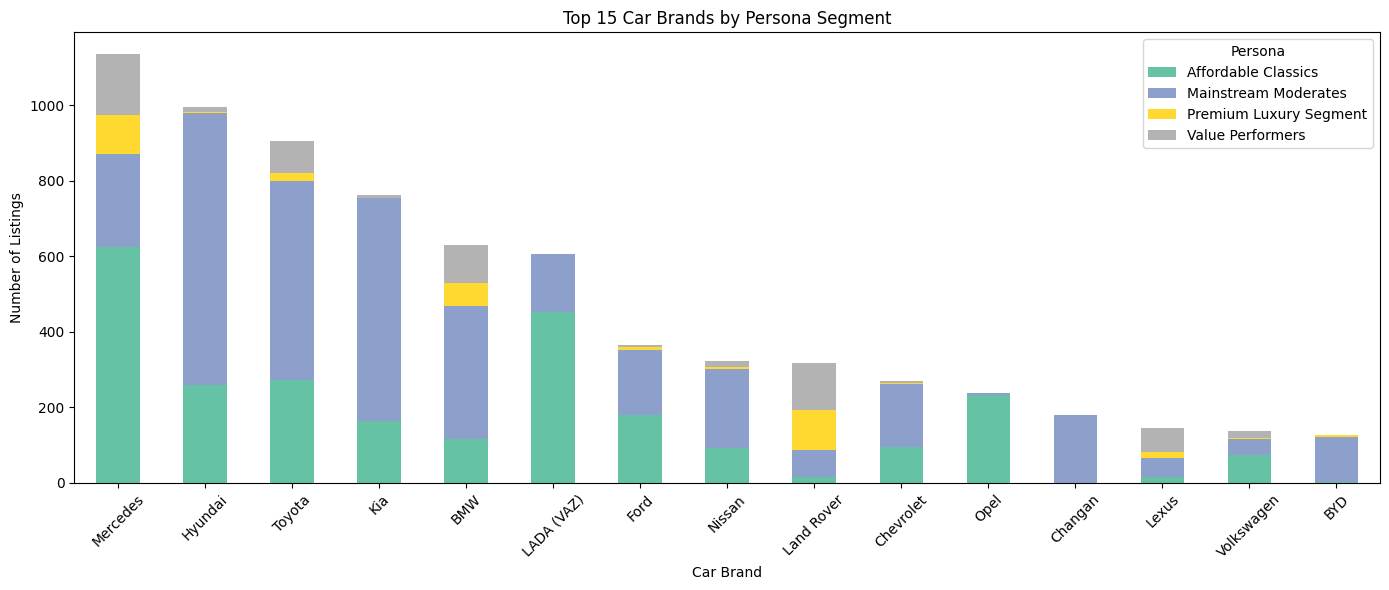

In [98]:
import matplotlib.pyplot as plt

brand_persona_top.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set2')

plt.title('Top 15 Car Brands by Persona Segment')
plt.xlabel('Car Brand')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.legend(title='Persona')
plt.tight_layout()
plt.show()

**3. Fuel Type Trends: Clusters showing preferences for diesel, petrol, hybrid, plug-in hybrid or fully electric vehicles.**

In [99]:
fuel_persona_counts = df.groupby(['fuel_type', 'persona']).size().unstack(fill_value=0)

fuel_order = ['Benzin', 'Dizel', 'Hibrid', 'Plug-in Hibrid', 'Elektro', 'Qaz'] 
fuel_persona_counts = fuel_persona_counts.loc[fuel_order]

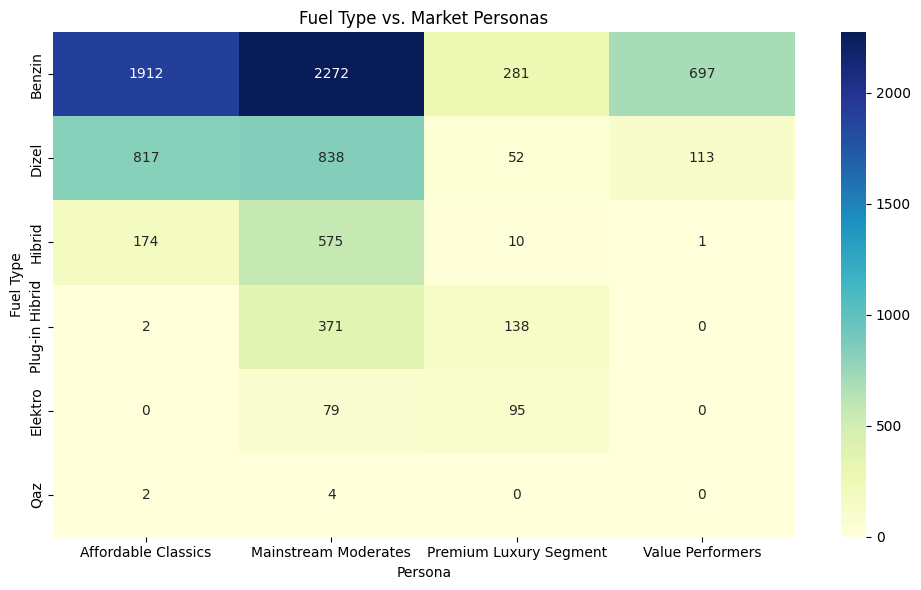

In [100]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(fuel_persona_counts, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Fuel Type vs. Market Personas')
plt.xlabel('Persona')
plt.ylabel('Fuel Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**4. Age-Mileage Patterns with top 15 brands: Insights into how vehicle age correlates with mileage across different clusters.**

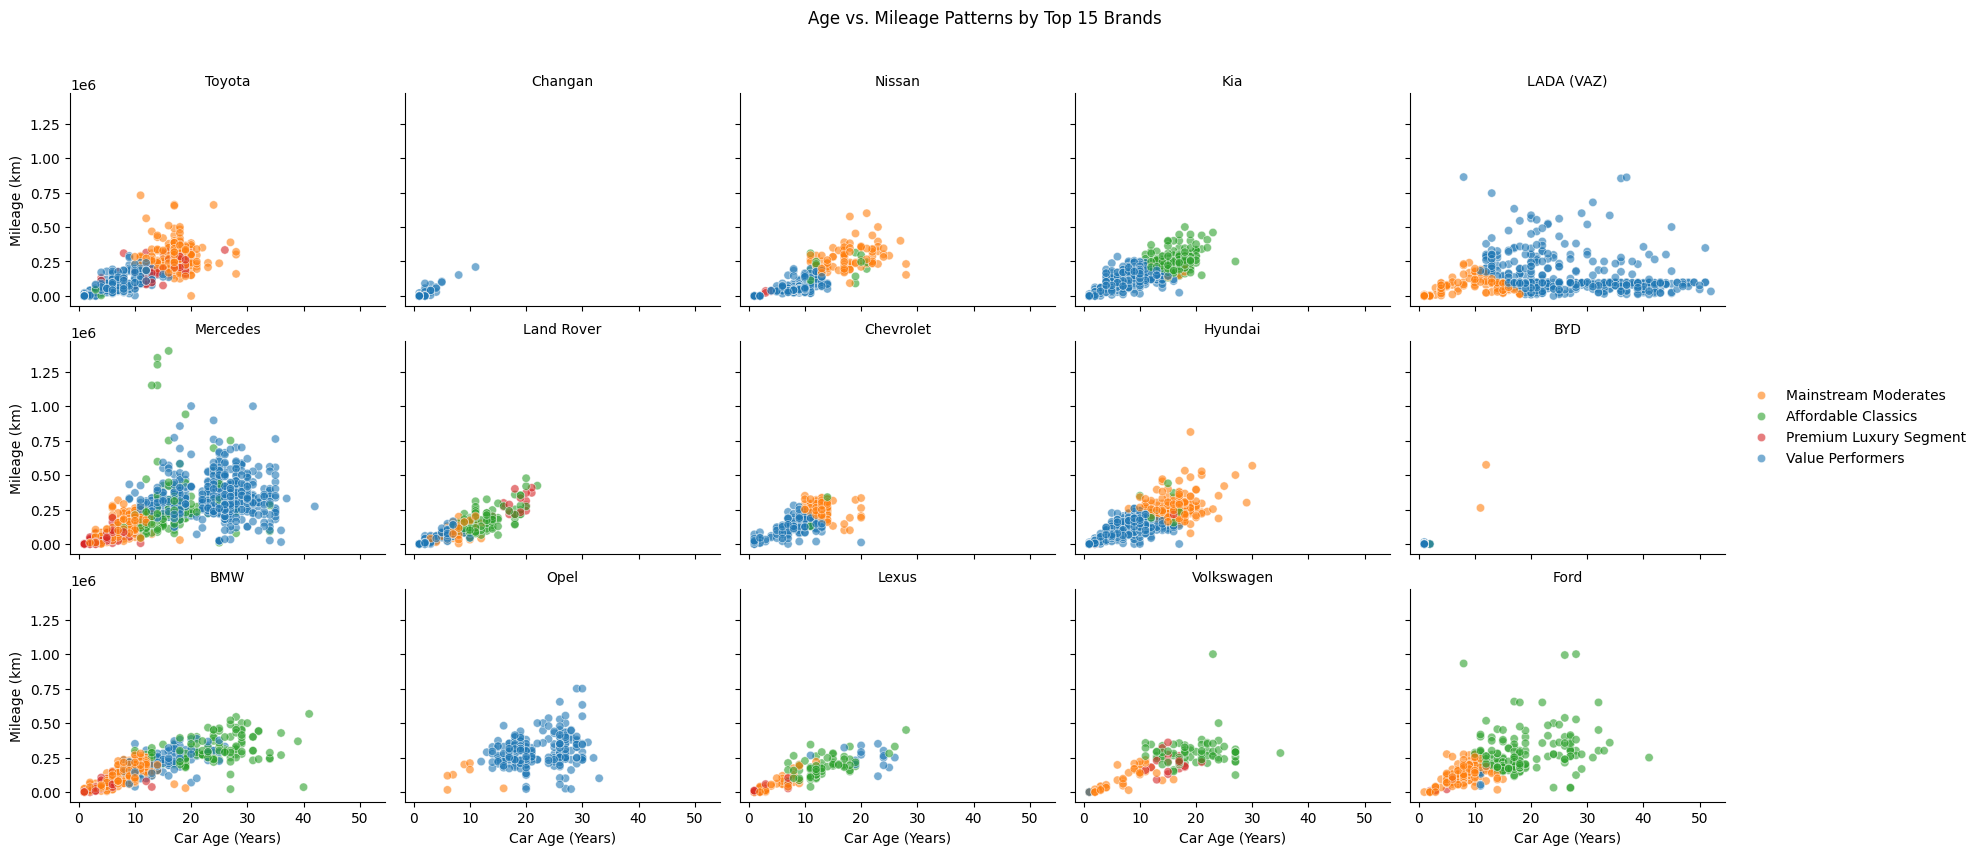

In [101]:
top_brands = df['make'].value_counts().head(15).index
df_top = df[df['make'].isin(top_brands)]

g = sns.FacetGrid(df_top, col='make', col_wrap=5, height=3.5, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x=2025 - df_top['year'], y='mileage', hue='persona', alpha=0.6)
g.set_axis_labels("Car Age (Years)", "Mileage (km)")
g.set_titles("{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Age vs. Mileage Patterns by Top 15 Brands")
plt.show()